C:\Users\domin\juwavelet\juwavelet\transform.py:324: RuntimeWarning: divide by zero encountered in divide
  wys = periods[:, np.newaxis] / (aspect * np.sin(thetas[np.newaxis, :]))
C:\Users\domin\juwavelet\juwavelet\transform.py:367: RuntimeWarning: divide by zero encountered in divide
  "wavelength_y": periods[:, np.newaxis] / (aspect * np.sin(thetas[np.newaxis, :])),
100%|███████████████████████████████████████████████████████████████████████| 307200/307200 [00:15<00:00, 19230.13it/s]
C:\Users\domin\AppData\Local\Temp\ipykernel_23836\919521009.py:121: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.pi / k, theta


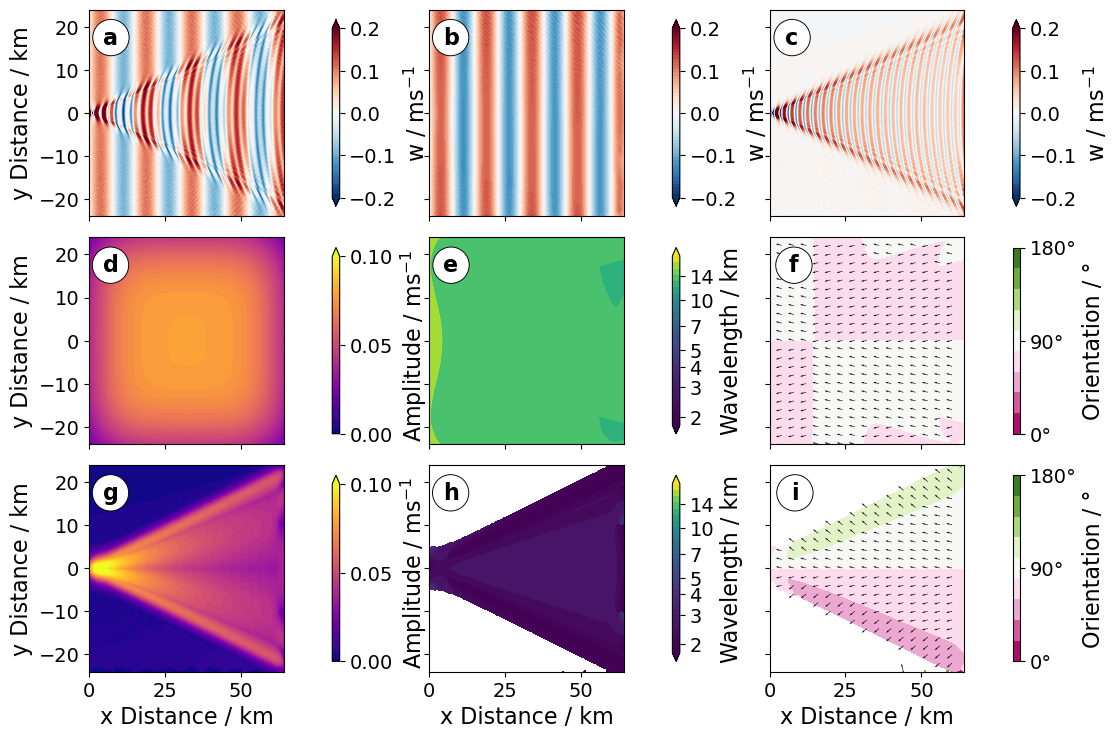

In [3]:
import copy
import itertools
from tqdm import tqdm

from juwavelet import transform

from scipy.ndimage import gaussian_filter
from skimage.segmentation import watershed
from skimage.morphology import local_minima
from skimage.measure import label

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({
    'axes.labelsize': 16,
    'font.size': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [2 * 6.94, 2 * 4.29],
})


def Kelvin_wake_pattern(dx, dy, nx, ny, U=2, g=9.81, L=1.0, nt=300):
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, nt)
    x = np.linspace(0, nx * dx, nx)
    y = np.linspace(-ny * dy / 2, ny * dy / 2, ny)
    X, Y = np.meshgrid(x, y)
    wavefield = np.zeros_like(X)

    for theta in theta_range:
        if np.abs(np.cos(theta)) < 1e-2:
            continue
        k = g / (U**2 * np.cos(theta)**2)
        phi = k * (X * np.cos(theta) + Y * np.sin(theta))
        wavefield += np.cos(phi) / np.sqrt(k)

    wavefield /= len(theta_range)

    return wavefield


def plane_wave(dx, dy, nx, ny, A=0.1, lh=15):
    x = np.linspace(0, nx * dx, nx)
    y = np.linspace(-ny * dy / 2, ny * dy / 2, ny)
    X, Y = np.meshgrid(x, y)

    return A * np.sin(2 * np.pi / lh * X)


def wavefield_segmentation(data, sigma):
    """
    Labels individual segments of a given dataset.

    Parameters
    ----------
    data : ndarray
        data to be segmented
    sigma : list of floats
        tuple of sigma values for the gaussian filter

    Returns
    -------
    ndarray
    """

    idata = np.max(data) - data  # Invert the data
    connection_param = len(data.shape)

    # First smooth the data in order to get rid of tiny minima and reduce the number of segments
    smoo_idata = gaussian_filter(idata, sigma=sigma)

    # Define the minima to be used by watershed segmentation
    mini = local_minima(smoo_idata, connectivity=connection_param, allow_borders=False)
    minima_pos = label(mini, connectivity=connection_param)

    return watershed(idata, connectivity=connection_param, markers=minima_pos)


def wavepaket_reconstruction(list_of_labels, CWT, segments):
    """
    Reconstructs a wavepaket based on the CWT and the labelled region within the WPS.
    wavefield_segmentation() must be done prior to the reconstruction.

    Parameters
    ----------
    list_of_labels : list of ints
        label(s) of the wavepaket that should be reconstructed
    CWT : dict
        dictionary containing among other things the wavelet coefficients to perform the reconstruction.
        dictionary is provided by juwavelet.transform.decompose()
    segments : array of ints
        an array of the same dimensions as the CWT['decomposition'] entry that marks clusters in the WPS
        and hence marks individual wave pakets.

    Returns
    -------
    ndarray
    """
    CWT_copy = copy.deepcopy(CWT)
    mask = np.isin(segments, list_of_labels)
    CWT_copy["decomposition"][~mask] = 0

    return transform.reconstruct2d(CWT_copy)


def kxky_2_lhtheta(kx, ky):
    """
    Convert the wave vector components into a wavelength and an orientation
    Keep in mind that arctan2() returns signed angles between [-np.pi,np.pi] defined from the positive x-axis
    while I defined my angles from [0,2*np.pi] going clockwise from the positive y-axis.
    """
    k = np.sqrt(kx**2 + ky**2)
    theta = np.arctan2(ky, kx)
    theta = np.pi / 2 - theta
    theta[theta < 0] = 2 * np.pi + theta[theta < 0]

    return 2 * np.pi / k, theta


def A_kx_ky(list_of_labels, CWT, segments):
    """
    Computes the wave paket properties such as wavelength, propagation direction and amplitude
    as function of x and y based on the CWT and the labelled region within the WPS.

    Parameters
    ----------
    list_of_labels : list of ints
        label(s) of the wavepaket which properties should be computed.
    CWT : dict
        dictionary containing among other things the wavelet coefficients.
        dictionary is provided by juwavelet.transform.decompose()
    segments : array of ints
        an array of the same dimensions as the CWT['decomposition'] entry that marks clusters in the WPS
        and hence marks individual wave pakets.

    Returns
    -------
    3 x ndarrays
    """

    dim = CWT['decomposition'].shape

    A = np.zeros(dim[2:4])
    kx = np.zeros(dim[2:4])
    ky = np.zeros(dim[2:4])

    T, P = np.meshgrid(CWT['theta'], CWT['period'])

    for i, j in tqdm(list(itertools.product(range(dim[2]), range(dim[3])))):
        mask = np.isin(segments[:, :, i, j], list_of_labels)
        if np.count_nonzero(mask) > 0:
            weights = np.abs(CWT["decomposition"][:, :, i, j]) ** 2
            if np.sum(weights[mask]) > 0:
                A[i, j] = np.sqrt(np.nanmax(weights[mask]))
                true_indices = np.argwhere(mask)
                max_index = np.argmax(weights[mask])
                true_max_index = true_indices[max_index]
                kx[i, j] = 2 * np.pi / P[true_max_index[0], true_max_index[1]] * \
                    np.sin(T[true_max_index[0], true_max_index[1]])
                ky[i, j] = 2 * np.pi / P[true_max_index[0], true_max_index[1]] * \
                    np.cos(T[true_max_index[0], true_max_index[1]])

    return A, kx, ky


dx, dy = 0.1, 0.1
nx, ny = 640, 480
x = np.linspace(0, nx * dx, nx)
y = np.linspace(-ny * dy / 2, ny * dy / 2, ny)
X, Y = np.meshgrid(x, y)

# Define the wave field as superposition of a plane wave and a ship wave
wavefield = plane_wave(dx, dy, nx, ny) + Kelvin_wake_pattern(dx, dy, nx, ny)

# Compute 2-D CWT
s0 = 2 * dx
dj = 1 / 8
js = int(1 / dj * np.log2(nx * dx / s0))
jt = 9

cwt_dict = transform.decompose2d(wavefield, dx, dy, s0, dj, js, jt, aspect=1,
                                 nxpad=None, nypad=None, opts={'param': 4},
                                 mode="scaled", dtype=np.complex128)

# Segment the Wavelet Power Spectrum into wave packets
WPS = np.abs(cwt_dict['decomposition'])**2
segments = wavefield_segmentation(WPS, [2, 2, 10, 10])

# Compute variance of each segment
total_var = np.sum(WPS)
segment_var = []
for label in range(1, np.max(segments) + 1):
    label_var = np.sum(WPS[segments == label]) / total_var / np.count_nonzero(np.any(segments == label))
    segment_var = np.append(segment_var, label_var)

s = np.argsort(segment_var)
s = np.flip(s)

# Reconstruct the two wave packets with the largest variances and compute associated wavelengths and orientations
amp_threshold = 0.02 * np.max(np.abs(wavefield))
rec_david = wavepaket_reconstruction(s[0] + 1, cwt_dict, segments)
rec_goliath = wavepaket_reconstruction(s[1] + 1, cwt_dict, segments)
A_david, kx_david, ky_david = A_kx_ky(s[0] + 1, cwt_dict, segments)
A_goliath, kx_goliath, ky_goliath = A_kx_ky(s[1] + 1, cwt_dict, segments)
lh_david, theta_david = kxky_2_lhtheta(kx_david, ky_david)
lh_goliath, theta_goliath = kxky_2_lhtheta(kx_goliath, ky_goliath)
lh_david[A_david < amp_threshold] = np.nan
theta_david[A_david < amp_threshold] = np.nan
lh_goliath[A_goliath < amp_threshold] = np.nan
theta_goliath[A_goliath < amp_threshold] = np.nan


num_levels = 51
w_lev = np.linspace(-0.2, 0.2, num_levels)
w_ticks = [-0.2, -0.1, 0, 0.1, 0.2]
A_lev = np.linspace(0, 0.1, num_levels)
A_ticks = [0, 0.05, 0.1]
theta_lev = np.linspace(0, np.pi, 10)

label = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
label_x1, label_y1 = 0.15, 0.92
letterbox = {"boxstyle": "circle", "lw": 0.67, "facecolor": "white", "edgecolor": "black"}
gskw = {"hspace": 0.1, "wspace": 0.4, "width_ratios": [10, 2.5, 10, 2.5, 10, 2.5], "height_ratios": [1, 1, 1]}

fig, axes = plt.subplots(3, 6, figsize=(12.54, 8.6), sharey=True, sharex=True, gridspec_kw=gskw)

for i in range(3):
    axes[i, 1].axis('off')
    axes[i, 3].axis('off')
    axes[i, 5].axis('off')

plot_orig = axes[0, 0].contourf(X, Y, wavefield, levels=w_lev, cmap='RdBu_r', extend='both')
cbar_orig = fig.colorbar(plot_orig, ax=axes[0, 1], location="right", ticks=w_ticks,
                         fraction=1, shrink=0.9, extend="both", label="w / ms$^{-1}$", aspect=25)

plot_david = axes[0, 2].contourf(X, Y, rec_david, levels=w_lev, cmap='RdBu_r', extend='both')
cbar_orig = fig.colorbar(plot_orig, ax=axes[0, 3], location="right", ticks=w_ticks,
                         fraction=1, shrink=0.9, extend="both", label="w / ms$^{-1}$", aspect=25)

plot_goliath = axes[0, 4].contourf(X, Y, rec_goliath, levels=w_lev, cmap='RdBu_r', extend='both')
cbar_orig = fig.colorbar(plot_orig, ax=axes[0, 5], location="right", ticks=w_ticks,
                         fraction=1, shrink=0.9, extend="both", label="w / ms$^{-1}$", aspect=25)

plot_amp_david = axes[1, 0].contourf(X, Y, A_david, levels=A_lev, cmap='plasma', extend='max')
cbar_amp = fig.colorbar(plot_amp_david, ax=axes[1, 1], location="right", ticks=A_ticks,
                        fraction=1, shrink=0.9, extend="max", label="Amplitude / ms$^{-1}$", aspect=25)

plot_amp_goliath = axes[2, 0].contourf(X, Y, A_goliath, levels=A_lev, cmap='plasma', extend='max')
cbar_amp = fig.colorbar(plot_amp_david, ax=axes[2, 1], location="right", ticks=A_ticks,
                        fraction=1, shrink=0.9, extend="max", label="Amplitude / ms$^{-1}$", aspect=25)

plot_lh_david = axes[1, 2].contourf(X, Y, lh_david, levels=cwt_dict['period'][20:48], extend='both')
cbar_lh = fig.colorbar(plot_lh_david, ax=axes[1, 3], location="right", ticks=np.round(cwt_dict['period'][20:48:4]),
                       fraction=1, shrink=0.9, extend="both", label="Wavelength / km", aspect=25)

plot_lh_goliath = axes[2, 2].contourf(X, Y, lh_goliath, levels=cwt_dict['period'][20:48], extend='both')
cbar_lh = fig.colorbar(plot_lh_goliath, ax=axes[2, 3], location="right", ticks=np.round(cwt_dict['period'][20:48:4]),
                       fraction=1, shrink=0.9, extend="both", label="Wavelength / km", aspect=25)

plot_theta_david = axes[1, 4].contourf(X, Y, theta_david, cmap='PiYG', levels=theta_lev)
cbar_theta = fig.colorbar(plot_theta_david, ax=axes[1, 5], location="right", ticks=[0, np.pi / 2, np.pi],
                          fraction=1, shrink=0.9, extend="both", label="Orientation / °", aspect=25)
cbar_theta.set_ticks(ticks=[0, np.pi / 2, np.pi], labels=(['0°', '90°', '180°']))
axes[1, 4].quiver(X[0::20, 0::40], Y[0::20, 0::40], -np.sin(theta_david[0::20, 0::40]), -
                  np.cos(theta_david[0::20, 0::40]), angles='xy', scale_units='xy', scale=0.5)

plot_theta_goliath = axes[2, 4].contourf(X, Y, theta_goliath, cmap='PiYG', levels=theta_lev)
cbar_theta = fig.colorbar(plot_theta_david, ax=axes[2, 5], location="right", ticks=[0, np.pi / 2, np.pi],
                          fraction=1, shrink=0.9, extend="both", label="Orientation / °", aspect=25)
cbar_theta.set_ticks(ticks=[0, np.pi / 2, np.pi], labels=(['0°', '90°', '180°']))
axes[2, 4].quiver(X[0::20, 0::40], Y[0::20, 0::40], -np.sin(theta_goliath[0::20, 0::40]), -
                  np.cos(theta_goliath[0::20, 0::40]), angles='xy', scale_units='xy', scale=0.5)

axes[0, 0].set_ylabel('y Distance / km')
axes[1, 0].set_ylabel('y Distance / km')
axes[2, 0].set_ylabel('y Distance / km')
axes[2, 0].set_xlabel('x Distance / km')
axes[2, 2].set_xlabel('x Distance / km')
axes[2, 4].set_xlabel('x Distance / km')

axes[0, 0].text(label_x1, label_y1, label[0], transform=axes[0][0].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")
axes[0, 2].text(label_x1, label_y1, label[1], transform=axes[0][2].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")
axes[0, 4].text(label_x1, label_y1, label[2], transform=axes[0][4].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")

axes[1, 0].text(label_x1, label_y1, label[3], transform=axes[1][0].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")
axes[1, 2].text(label_x1, label_y1, label[4], transform=axes[1][2].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")
axes[1, 4].text(label_x1, label_y1, label[5], transform=axes[1][4].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")

axes[2, 0].text(label_x1, label_y1, label[6], transform=axes[2][0].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")
axes[2, 2].text(label_x1, label_y1, label[7], transform=axes[2][2].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")
axes[2, 4].text(label_x1, label_y1, label[8], transform=axes[2][4].transAxes, bbox=letterbox,
                verticalalignment="top", horizontalalignment="right", weight="bold")

plt.savefig('segment_2d.png', dpi=120, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.savefig('segment_2d.pdf', dpi=120, facecolor="w", edgecolor="w", bbox_inches="tight")
